In [1]:
print("Starting")
from datetime import datetime as dt
print(f"{dt.now().strftime('%X')}: Imported datetime.")
      
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchmetrics
from tqdm.auto import tqdm

sns.set()
print(f"{dt.now().strftime('%X')}: Seaborn is set.")
import numpy as np
import os
import pandas as pd
import sys

print(f"{dt.now().strftime('%X')}: Importing own library.")
sys.path.append("..")
import hydra
from src.lib.config import register_configs
from src.utils.EvalWrapper import EvalWrapper

print(f"{dt.now().strftime('%X')}: Trying to register configs.")
register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)

print(f"{dt.now().strftime('%X')}: succesfully initialized hydra")
import pytorch_lightning as pl
import pickle
from eval_single_helper_funcs import instantiate_trainer, run_and_save, get_confidence_and_acc_single, get_temperature_file, get_distribution_file
print(f"{dt.now().strftime('%X')}: done.")

Starting
14:01:22: Imported datetime.
14:01:45: Seaborn is set.
14:01:45: Importing own library.
14:01:47: Trying to register configs.
14:01:48: succesfully initialized hydra
14:01:57: done.


In [2]:
# set global values:

experiments_singlelabel = {
    "supervised_singlelabel": "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-04-19/08-14-50",
    "linear_singlelabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-04-19/19-15-20",
    "finetune_singlelabel": "/gpfs/work/machnitz/plankton_logs/finetune/singlelabel/multirun/2022-04-19/08-15-24",
    "finetune_sgd_singlelabel": "/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-04-19/08-15-10"
}

data_splits_per_experiment = [np.round(x, 2) for x in np.arange(0.01, 0.1, 0.01)] + [np.round(x, 2) for x in
                                                                                     np.arange(0.1, 1.1, 0.1)]
# data_splits_per_experiment = data_splits_per_experiment[::-1]
print("Data splits: ", data_splits_per_experiment)

Data splits:  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [3]:
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

# Single Label

In [4]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_singlelabel",
                                                     "random_seed=7",
                                                     "strategy=SingleDevice",
                                                     'strategy.device="cuda:0"',
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=200",
                                                     "lightning_module.log_confusion_matrices=false",
                                                     "lightning_module.temperature_scale=false",
                                                     ])

Global seed set to 7


In [5]:

train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="test")

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
77it [00:00, 4202.05it/s]                                                                                                                                                              | 0/19 [00:00<?, ?it/s]
4536it [00:00, 7365.80it/s]
88it [00:00, 7882.85it/s]████████████▏                                                                                                                                         | 2/19 [00:00<00:05,  3.12it/s]
100it [00:00, 8524.66it/s]
95it [00:00, 9750.85it/s]
288it [00:00, 10446.31it/s]
12it [00:00, 5269.78it/s]
158it [00:00, 10438.19it/s]
59it [00:00, 11225.40it/s]
1215it [00:00, 17893.79it/s]
386it [00:00, 22746.13it/s]██████████████████████████████████████████████████████████████████████████▌      

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


  0%|          | 0/19 [00:00<?, ?it/s]

0
loading supervised_singlelabel_0 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


1
loading supervised_singlelabel_1 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


2
loading supervised_singlelabel_2 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


3
loading supervised_singlelabel_3 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


4
loading supervised_singlelabel_4 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


5
loading supervised_singlelabel_5 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


6
loading supervised_singlelabel_6 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


7
loading supervised_singlelabel_7 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


8
loading supervised_singlelabel_8 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


9
loading supervised_singlelabel_9 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


10
loading supervised_singlelabel_10 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


11
loading supervised_singlelabel_11 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


12
loading supervised_singlelabel_12 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


13
loading supervised_singlelabel_13 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


14
loading supervised_singlelabel_14 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


15
loading supervised_singlelabel_15 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


16
loading supervised_singlelabel_16 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


17
loading supervised_singlelabel_17 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


18
loading supervised_singlelabel_18 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


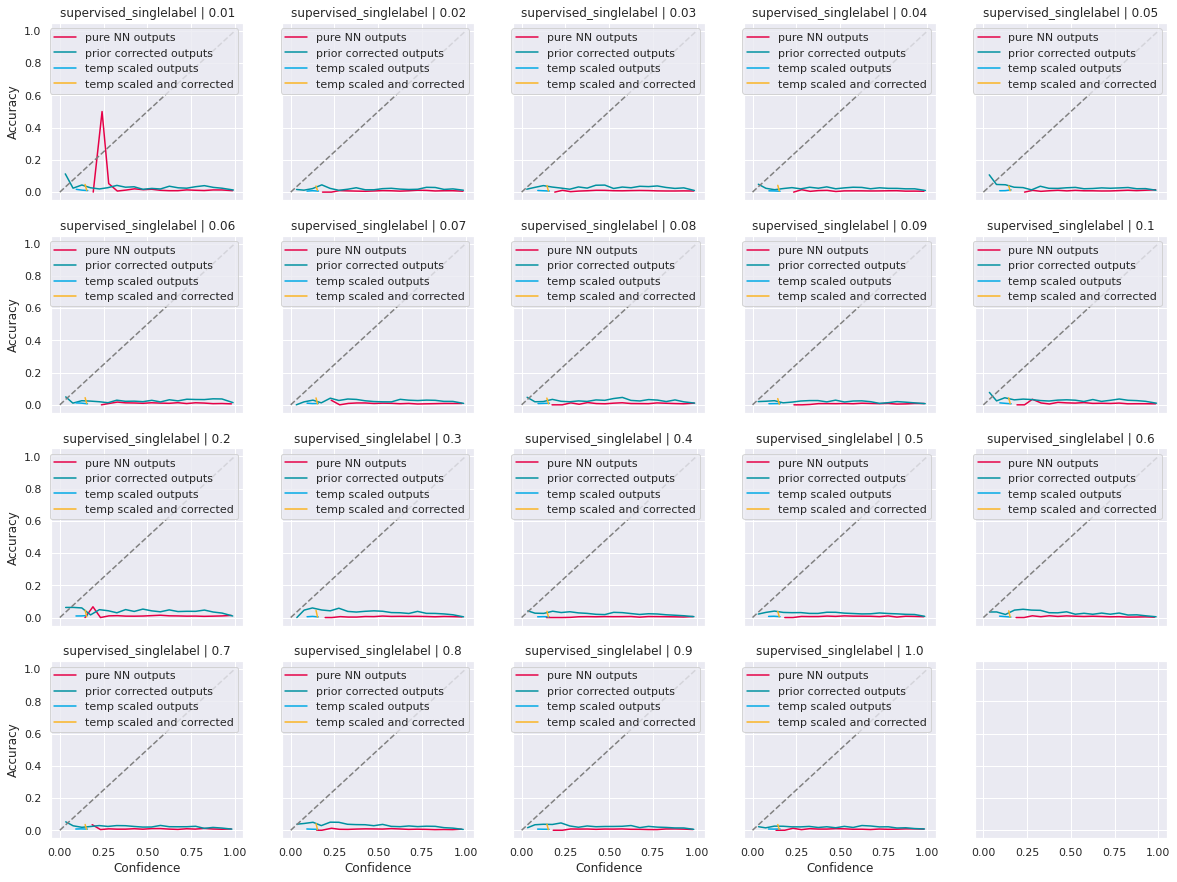

  0%|          | 0/19 [00:00<?, ?it/s]

0
loading linear_singlelabel_0 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


1
loading linear_singlelabel_1 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


2
loading linear_singlelabel_2 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


3
loading linear_singlelabel_3 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


4
loading linear_singlelabel_4 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


5
loading linear_singlelabel_5 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


6
loading linear_singlelabel_6 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


7
loading linear_singlelabel_7 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


8
loading linear_singlelabel_8 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


9
loading linear_singlelabel_9 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


10
loading linear_singlelabel_10 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


11
loading linear_singlelabel_11 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


12
loading linear_singlelabel_12 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


13
loading linear_singlelabel_13 from file
14


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)
/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


loading linear_singlelabel_14 from file
15
loading linear_singlelabel_15 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


16
loading linear_singlelabel_16 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


17
loading linear_singlelabel_17 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)
/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


18
loading linear_singlelabel_18 from file


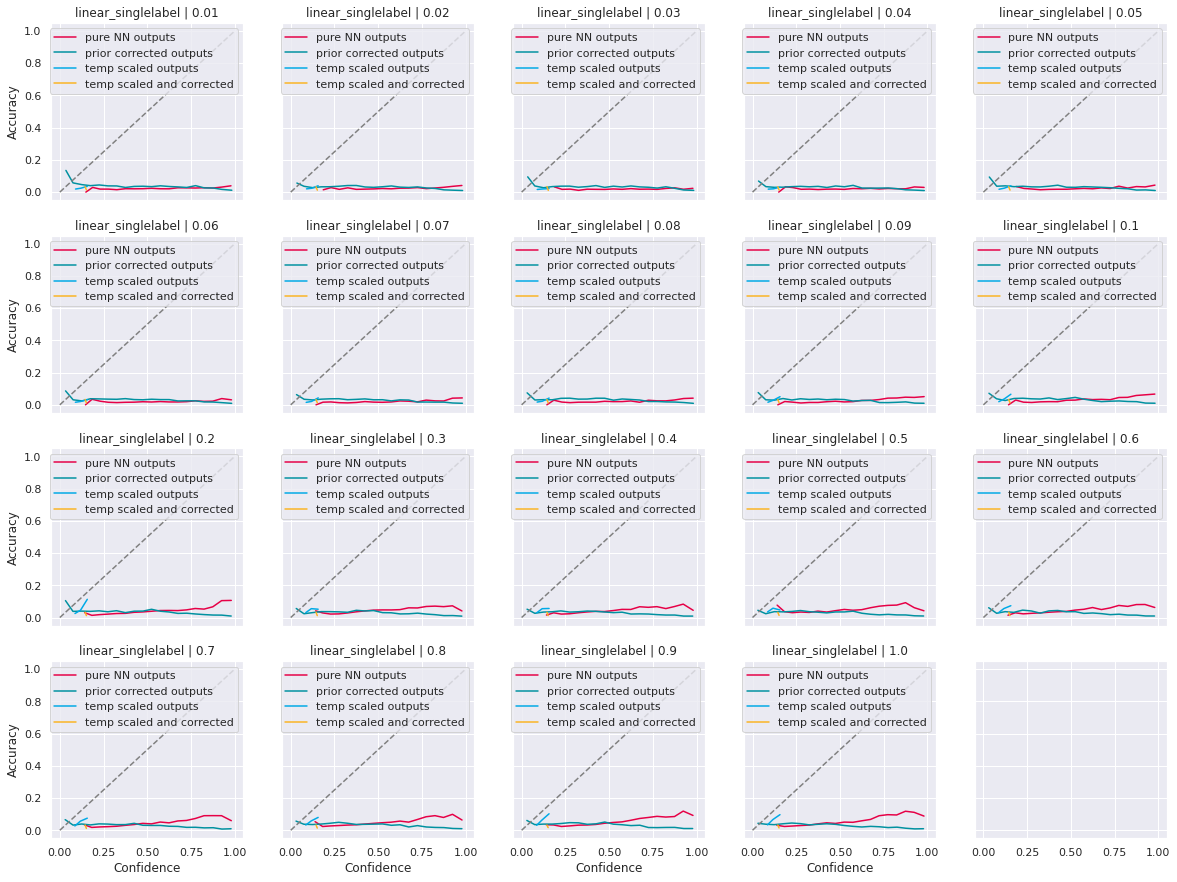

  0%|          | 0/19 [00:00<?, ?it/s]

0
loading finetune_singlelabel_0 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


1
loading finetune_singlelabel_1 from file
2


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)
/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


loading finetune_singlelabel_2 from file
3
loading finetune_singlelabel_3 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


4
loading finetune_singlelabel_4 from file
5


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


loading finetune_singlelabel_5 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


6
loading finetune_singlelabel_6 from file
7
loading finetune_singlelabel_7 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)
/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


8
loading finetune_singlelabel_8 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


9
loading finetune_singlelabel_9 from file
10


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)
/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


loading finetune_singlelabel_10 from file
11
loading finetune_singlelabel_11 from file


/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


12


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 200. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 174. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.0030751207377761602   │
│       loss/Testing        │    23.808603286743164     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


13


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.0023185433819890022   │
│       loss/Testing        │     24.63692283630371     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


14


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.002709035063162446    │
│       loss/Testing        │    18.672325134277344     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


15


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.002001269022002816    │
│       loss/Testing        │    14.583281517028809     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.002245326293632388    │
│       loss/Testing        │    21.353471755981445     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.0028554692398756742   │
│       loss/Testing        │     17.44809341430664     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


18


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.00229413784109056    │
│       loss/Testing        │     19.17118263244629     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

/gpfs/home/machnitz/plankton-classifier-git/notebooks/../src/utils/EvalWrapper.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


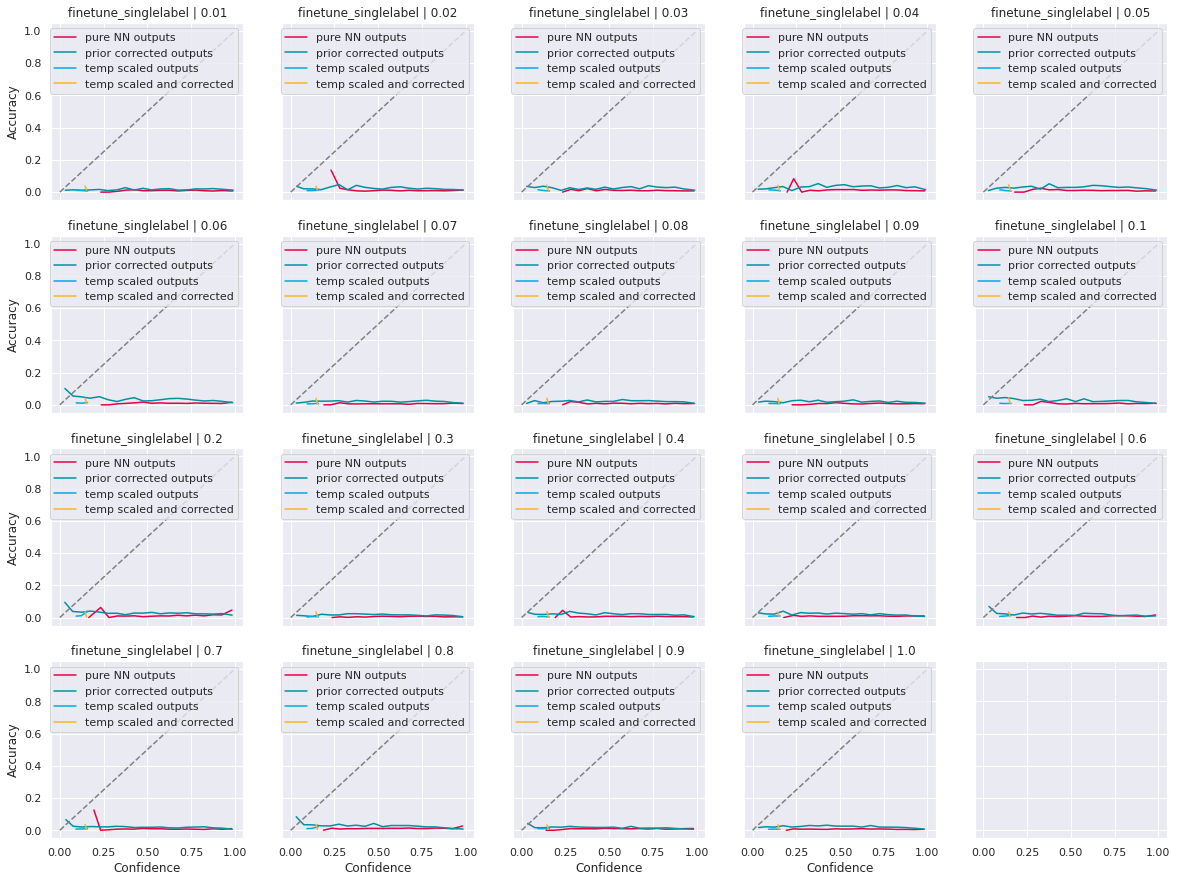

  0%|          | 0/19 [00:00<?, ?it/s]

0


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-04-19/08-15-10/0/logs/checkpoints/epoch=04.ckpt'

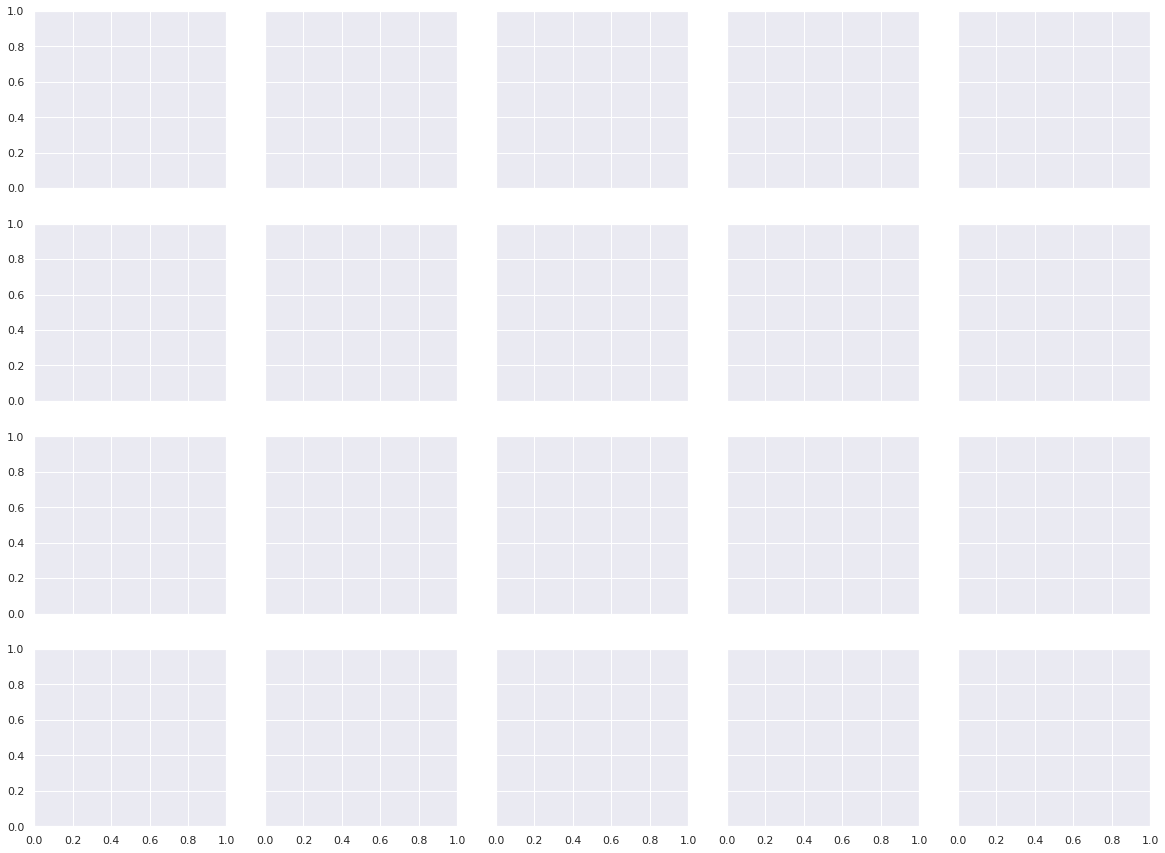

In [6]:
# trainer = instantiate_trainer(cfg)
#
# test_dataloader = datamodule.test_dataloader()
# for example_input, _ in test_dataloader:
#     break

acc_func = torchmetrics.Accuracy(average="none", num_classes=len(datamodule.unique_labels))
best_checkpoints = []
return_metrics = dict()
for key, setup_path in experiments_singlelabel.items():
    experiment_folders = [os.path.join(setup_path, str(i)) for i in np.arange(0, 19)]
    return_metrics[key] = dict()
    # fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15), sharex=True, sharey=True)
    for experiment_number, experiment_path in enumerate(tqdm(experiment_folders)):
        print(experiment_number)
        with open(os.path.join(experiment_path, "main.log"), "r") as f:
            complete_log = f.readlines()
            found_best_checkpoint = False
            for line in complete_log:
                # print(line)
                if found_best_checkpoint:
                    best_checkpoint = line.strip()
                    # print(f"set best checkpoint to {best_checkpoint}")
                    break

                if "[main.main][INFO] - Best checkpoint path:" in line:
                    found_best_checkpoint = True
                    # print(f"found best checkpoint: {line}")
        best_checkpoints.append(best_checkpoint)
    #     if os.path.isfile(f"test_results/labels_{key}_{experiment_number}.pt"):
    #         print(f"loading {key}_{experiment_number} from file")
    #         logits = torch.load(f"test_results/logits_{key}_{experiment_number}.pt")
    #         labels = torch.load(f"test_results/labels_{key}_{experiment_number}.pt")
    #         with open(f"test_results/dict_{key}_{experiment_number}.pkl", 'rb') as f:
    #             return_metrics = pickle.load(f)
    #     else:
    #         logits, labels, return_metrics = run_and_save(best_checkpoint, test_dataloader, return_metrics, key,
    #                                                       experiment_number, data_splits_per_experiment, trainer,
    #                                                       datamodule, example_input)
    #
    #     accuracies, confidences, ece = get_confidence_and_acc_single(logits, labels)
    #     return_metrics[key][experiment_number]["ECE"] = ece
    #
    #     prob_scaling = EvalWrapper(temperature_file=get_temperature_file(best_checkpoint),
    #                                training_distribution_file=get_distribution_file(best_checkpoint),
    #                                device="cpu")
    #
    #     corrected_probabilities = prob_scaling(logits=logits, correct_probabilities_with_training_prior=True)
    #     accuracies_corrected, confidences_corrected, ece_corrected = get_confidence_and_acc_single(
    #         corrected_probabilities,
    #         labels,
    #         logits_are_probs=True)
    #     temp_scaled_logits = prob_scaling(logits=logits, correct_probabilities_with_temperature=True)
    #     accuracies_temp, confidences_temp, ece_temp = get_confidence_and_acc_single(temp_scaled_logits,
    #                                                                                 labels,
    #                                                                                 logits_are_probs=False)
    #     temp_and_prior_corrected_probabilities = prob_scaling(logits=temp_scaled_logits,
    #                                                           correct_probabilities_with_training_prior=True)
    #     accuracies_temp_and_corrected, confidences_temp_and_corrected, ece_temp_and_corrected = get_confidence_and_acc_single(
    #         temp_and_prior_corrected_probabilities, labels, logits_are_probs=False)
    #
    #     ax = axes.flatten()[experiment_number]
    #     sns.lineplot(x=confidences.cpu().numpy(), y=accuracies.cpu().numpy(), ax=ax, label="pure NN outputs")
    #     sns.lineplot(x=confidences_corrected.cpu().numpy(), y=accuracies_corrected.cpu().numpy(), ax=ax,
    #                  label="prior corrected outputs")
    #     sns.lineplot(x=confidences_temp.cpu().numpy(), y=accuracies_temp.cpu().numpy(), ax=ax,
    #                  label="temp scaled outputs")
    #     sns.lineplot(x=confidences_temp_and_corrected.cpu().numpy(), y=accuracies_temp_and_corrected.cpu().numpy(),
    #                  ax=ax, label="temp scaled and corrected")
    #     ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c="grey", ls="--")
    #     ax.set_xlabel("Confidence")
    #     ax.set_ylabel("Accuracy")
    #     ax.set_title(f"{key} | {data_splits_per_experiment[experiment_number]}")
    #     ax.legend(loc="best")
    # plt.savefig(f"ConfidenceAccuracy{key}.png", dpi=300)
    # plt.show()
    # plt.close("all")


In [ ]:

datamodule.setup(stage="fit")
val_dataloader = datamodule.val_dataloader()

for batch in val_dataloader:
    example_input, _ = batch
    break

val_logits, val_labels, val_return_metrics = run_and_save(best_checkpoint, val_dataloader, return_metrics,
                                                          key + "valid", experiment_number)

In [ ]:

datamodule.setup(stage="test")
test_dataloader = datamodule.test_dataloader()

for batch in test_dataloader:
    example_input, _ = batch
    break

test_logits, test_labels, test_return_metrics = run_and_save(best_checkpoint, test_dataloader, return_metrics,
                                                             key + "test_new", experiment_number)

In [7]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in
          innerDict.items()}
single_label_df = pd.DataFrame.from_dict(reform).T
single_label_df.index.names = ("Model", "Experiment")
single_label_df

loss/Testing  Accuracy/Testing  \
Model                  Experiment                                   
supervised_singlelabel 0              36.211296          0.012813   
                       1              23.212234          0.007444   
                       2              31.182507          0.007907   
                       3              22.379311          0.006175   
                       4              20.843979          0.005613   
                       5              51.151085          0.006468   
                       6              34.965897          0.005809   
                       7              61.150780          0.005272   
                       8              31.829416          0.004515   
                       9              29.722326          0.004832   
                       10             33.100121          0.004393   
                       11             31.592155          0.003685   
                       12             22.124550          0.002416   
                       13             28.095844          0.002221   
                       14             20.360476          0.002733   
                       15             14.837157          0.001952   
                       16             23.649969          0.002416   
                       17             21.249111          0.002709   
                       18             18.966959          0.002611   
linear_singlelabel     0              19.691454          0.003978   
                       1              21.086702          0.004173   
                       2              22.905708          0.003197   
                       3              23.715599          0.003222   
                       4              23.471561          0.003075   
                       5              25.169250          0.003197   
                       6              25.387520          0.003051   
                       7              23.745258          0.003856   
                       8              33.531036          0.002929   
                       9              28.734444          0.003124   
                       10             33.226200          0.003319   
                       11             30.698235          0.003636   
                       12             28.954153          0.003636   
                       13             23.696527          0.003612   
                       14             22.026939          0.003563   
                       15             22.344833          0.003148   
                       16             20.496424          0.003929   
                       17             19.630068          0.003685   
                       18             20.456076          0.003490   
finetune_singlelabel   0              32.173477          0.012496   
                       1              29.969622          0.009836   
                       2              24.634592          0.007590   
                       3              28.317379          0.008713   
                       4              34.403839          0.007078   
                       5              27.026266          0.005784   
                       6              52.245766          0.004759   
                       7              27.751024          0.005150   
                       8              30.620512          0.005540   
                       9              45.932560          0.004515   
                       10             33.779381          0.004295   
                       11             29.541874          0.003929   
                       12             23.808603          0.003075   
                       13             24.636923          0.002319   
                       14             18.672325          0.002709   
                       15             14.583282          0.002001   
                       16             21.353472          0.002245   
                       17             17.448093          0.002855   
                       18        

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="Data Fraction", y="Accuracy/Testing", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

for item in data_splits_per_experiment:
    ax.text(item, 0.2, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("ECE_Testing_Singlelabel.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

for item in data_splits_per_experiment:
    ax.text(item, 2, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("NLL_Testing_Singlelabel.png", dpi=300)